<h1> Global Variables & Paths <h1>

In [1]:
# --------------------------------------------------------- Global Variables & Paths
# region
# @title Global Variables & Paths { display-mode: "form" }
import os

# --------------- vscode
VS_CODE_RAW_DATA_SET_PATH = r"C:\Users\Dell\Desktop\Bachelor\datasets\26 letters\1800\1800 letters only" # modify per data set
VS_CODE_CLEAN_DATA_SET_PATH = '../image_classification/data/clean_data'

# --------------- kaggle
KAGGLE_RAW_DATA_SET_PATH = '/kaggle/input/arabic-handwritten-letters-and-numbers/Dataset' # put (dataset name immediately after /input), and any extra folders modify per data set
KAGGLE_CLEAN_DATA_SET_PATH = '/kaggle/working/clean_data'


# --------------- colab
KAGGLE_CRED_PATH = '/content/gdrive/MyDrive/Bachelor/kaggle'
KAGGLE_DATA_SET_NAME = 'mahmoudreda55/arabic-letters-numbers-ocr'  # username/dataset name..t modify per data set
COLAB_RAW_DATA_SET_PATH = '/content/kaggle_data/Dataset' # put (dataset_name) after (kaggle_data) , then put any extra folders... modify the part after (kaggle_data) per data set
COLAB_CLAEN_DATA_SET_PATH = '/content/clean_data'

# ----------------- global variables
EPOCHS = 100
DATA_PERCENTAGE_TO_USE = 100
image_size = 16
USE_RAW_DATA = True
RENAME_CLEAN_DATA = False
CLUSTERS_COUNT = 2



print("img size: ", image_size)
print('Global Variables & Paths are set successfully.')
# endregion

img size:  16
Global Variables & Paths are set successfully.


<h1> time calculation function <h1>

In [2]:
# --------------------------------------------------------- time calculation function
# region
# @title time calculation function { display-mode: "form" }


import time

global_start_time = time.time() # to calculate time taken for the whole notebook to run
def calculate_and_print_time(start_time , section_name):
    end_time = time.time()
    time_taken = end_time - start_time
    hours = int(time_taken // 3600)
    minutes = int((time_taken % 3600) // 60)
    seconds = int((time_taken % 3600) % 60)
    print(f'\n{section_name} done in : {hours} h, {minutes} m, {seconds} s')

print('time calculation function is set successfully.')

time calculation function is set successfully.


<h1> install libraries <h1>

In [3]:
# --------------------------------------------------------- install libraries
# region
# @title install libraries { display-mode: "form" }



start_time = time.time()

import pkg_resources
REQUIRED_PACKAGES = ['seaborn', 'tensorflow','natsort']

for package in REQUIRED_PACKAGES:
    try:
        dist = pkg_resources.get_distribution(package)
        print('{} ({}) is installed'.format(dist.key, dist.version))
    except pkg_resources.DistributionNotFound:
        print('{} is NOT installed'.format(package))
        %pip install {package} 
# uninstall the standalone keras package to force using the one installed with tensorflow
# %pip uninstall keras -y


calculate_and_print_time(start_time, 'installing required packages')
# print("installing required packages done")
# endregion

seaborn (0.13.2) is installed
tensorflow (2.16.1) is installed
natsort (8.4.0) is installed

installing required packages done in : 0 h, 0 m, 0 s


<h1> imports <h1>

In [4]:
# --------------------------------------------------------- imports
# region
# @title imports { display-mode: "form" }
start_time = time.time()

import os

import uuid
import time
import json
import random
import warnings
import shutil
import zipfile
from natsort import natsorted
from os import makedirs
from os import listdir
from tqdm import tqdm
from shutil import copyfile
from random import seed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
# import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.preprocessing import image
from sklearn.cluster import KMeans

calculate_and_print_time(start_time, 'imports')
# print("imports done")

# endregion




imports done in : 0 h, 0 m, 52 s


<h1> detect Hardware <h1>

In [5]:
# --------------------------------------------------------- detect Hardware
# region
# @title detect Hardware {display-mode: "form"}
start_time = time.time()

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
    print('TPU details: ', tpu.cluster_spec().as_dict())
except ValueError:
    tpu = None
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if(gpus):
        print("Running on ", len(gpus), " GPU(s) ")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy(devices=["GPU:{}".format(i) for i in range(len(gpus))])
    else:        
        print("Running on CPU")

print("REPLICAS: ", strategy.num_replicas_in_sync)
calculate_and_print_time(start_time,'detecting hardware')
# extra
# endregion

Running on CPU
REPLICAS:  1

detecting hardware done in : 0 h, 0 m, 0 s


<h1> functions <h1>

In [6]:
# --------------------------------------------------------- functions
# region
# @title functions {display-mode: "form"}
start_time = time.time()

raw_data_path = None
clean_data_path = None

def get_environment():
    if 'COLAB_GPU' in os.environ:
        return 'Google Colab'
    elif 'KAGGLE_URL_BASE' in os.environ:
        return 'Kaggle'
    elif 'VSCODE_PID' in os.environ:
        return 'VS Code'
    else:
        return 'Unknown environment'

def do_colab_staff():

    from google.colab import drive
    drive.mount('/content/gdrive')

    # storing kaggle credentials
    os.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_CRED_PATH

    !kaggle datasets download -d {KAGGLE_DATA_SET_NAME}
    print("downloaded dataset" ,KAGGLE_DATA_SET_NAME )
    
    
    ! mkdir kaggle_data
    downloaded_zip_name = f"{KAGGLE_DATA_SET_NAME.split('/')[-1]}.zip" # the !kaggle datasets download command will download the zip file with the same name as the dataset name
    extract_folder_path = 'kaggle_data'
    extract_zip(downloaded_zip_name, extract_folder_path)

    global raw_data_path
    raw_data_path = COLAB_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = COLAB_CLAEN_DATA_SET_PATH


def do_kaggle_staff():
    global raw_data_path
    raw_data_path = KAGGLE_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = KAGGLE_CLEAN_DATA_SET_PATH
    
def do_vscode_staff():
    global raw_data_path
    raw_data_path = VS_CODE_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = VS_CODE_CLEAN_DATA_SET_PATH

def do_unknown_environment_staff():
    print("This is an unknown environment, please enter the path to the data set folder:")
    global raw_data_path
    raw_data_path = input()     

def image_is_ok(image_path):
    with warnings.catch_warnings(record=True) as w:
        try:
            img = Image.open(image_path)
            img.verify()
            if len(w) > 0:  # if any warnings were issued
                return False
            return True
        except (IOError, SyntaxError):
            return False

def copy_clean_files(dirty_dataset_path, destination_folder_path):
    print("copying clean files...")
    # If the destination directory already exists, remove it and all its contents
    if os.path.exists(destination_folder_path):
        print(f"removing {destination_folder_path} directory to create a new one...")
        shutil.rmtree(destination_folder_path)
        print(f"removed {destination_folder_path} directory to create a new one...")
    os.makedirs(destination_folder_path)
    
    # Get the total number of files for the progress bar
    total_files = sum([len(files) for r, d, files in os.walk(dirty_dataset_path)])
    
    progress_bar = tqdm(total=total_files, desc="Copying files", unit="file")
    
    for root, dirs, files in os.walk(dirty_dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            if image_is_ok(file_path):
                new_file_path = os.path.join(destination_folder_path, os.path.relpath(file_path, dirty_dataset_path))
                os.makedirs(os.path.dirname(new_file_path) , exist_ok=True)
                shutil.copyfile(file_path, new_file_path)
            else:
                print(f"file: {os.path.relpath(file_path, dirty_dataset_path)} is corrupted & skipped from dataset while copying ")
            
            progress_bar.update(1)
    
    progress_bar.close()
    print(f"copied files from {dirty_dataset_path} to {destination_folder_path} successfully") 

def rename_files(data_set_path):
    all_entities_names = natsorted(os.listdir(data_set_path))
    print("giving temporary unique names...")
    for entity_name in all_entities_names:
        entity_path = os.path.join(data_set_path, entity_name)
        for filename in os.listdir(entity_path):
            temp_filename = str(uuid.uuid4()) + ".jpg"  # generate a unique filename
            source = os.path.join(entity_path, filename)
            destination = os.path.join(entity_path, temp_filename)
            os.rename(source, destination)
    # ----------------------------------------------------------------------------------------------------
    print("renaming...")
    # then rename every file in every folder in the given path

    for entity_name in all_entities_names:
        entity_path = os.path.join(data_set_path, entity_name)
        i = 1
        for filename in os.listdir(entity_path):
            entity_name = os.fsdecode(entity_name.lower())
            new_filename = entity_name + '.' + str(i) + ".jpg"
            source = os.path.join(entity_path, filename)
            destination = os.path.join(entity_path, new_filename)
            os.rename(source, destination)
            i += 1
    print("done renaming !")

def find_image_folder_after_extracting_zip(extracted_folder_path):
    for root, dirs, files in os.walk(extracted_folder_path):
        # check if the current directory contains image files
        if any(fname.lower().endswith(('.png', '.jpg', '.jpeg')) for fname in files):
            return os.path.dirname(root)
    return None

def extract_zip(source_path, destination_path):
    # delete the destination folder if it exists
    if os.path.exists(destination_path):
        print('Deleting the existing destination folder...')
        shutil.rmtree(destination_path)

    print("Extracting files...") 
    with zipfile.ZipFile(source_path, 'r') as zip_ref:
        files = zip_ref.infolist()
        for file in tqdm(files, desc="Extracting files", unit="file"):
            try:
                file.filename = file.filename.encode('cp437').decode('utf-8')  # try 'cp437' encoding first
            except UnicodeDecodeError:
                file.filename = file.filename.encode('utf-8').decode('utf-8')  # fallback to 'utf-8' if 'cp437' fails
            zip_ref.extract(file, path=destination_path)

    print("Extraction complete.")


calculate_and_print_time(start_time, 'functions')
# print("functions done")
# endregion

    


functions done in : 0 h, 0 m, 0 s


<h1> doing specific-environment things <h1>

In [7]:
# --------------------------------------------------------- doing specific-environment things
# region
# @title doing specific-environment things {display-mode: "form"}
start_time = time.time()

# test if the tpu & GPU is available

raw_data_path = None    
environment_type = get_environment() 
print(f'Environment: {environment_type}')     

print("tensowflow version:", tf.__version__)
if environment_type == 'Google Colab':
    do_colab_staff()
elif environment_type == 'Kaggle':
    do_kaggle_staff()
elif environment_type == 'VS Code':
    do_vscode_staff()
else:
    do_unknown_environment_staff()

print("raw data set path:", raw_data_path)
assert os.path.exists(raw_data_path), ' wrong path for data set !' 
print("clean data set path:", clean_data_path)
  
calculate_and_print_time(start_time, 'doing specific-environment things')
# print("doing specific-environment things done")

# endregion

        


Environment: VS Code
tensowflow version: 2.16.1
raw data set path: C:\Users\Dell\Desktop\Bachelor\datasets\26 letters\1800\1800 letters only
clean data set path: ../image_classification/data/clean_data

doing specific-environment things done in : 0 h, 0 m, 0 s


<h1> data preparation <h1>

In [8]:
# --------------------------------------------------------- data preparation
# region
# @title data preparation {display-mode: "form"}
start_time = time.time()

print("raw data path:", raw_data_path)
if USE_RAW_DATA:
    ready_data_path = raw_data_path
    print("we will use raw data directly")
else :
    copy_clean_files(raw_data_path, clean_data_path)
    if RENAME_CLEAN_DATA:
        rename_files(clean_data_path)
    ready_data_path = clean_data_path        

# ----------------------------

print("we will use ", DATA_PERCENTAGE_TO_USE, "% of the data")
calculate_and_print_time(start_time, 'data preparation')

# endregion
        


raw data path: C:\Users\Dell\Desktop\Bachelor\datasets\26 letters\1800\1800 letters only
we will use raw data directly
we will use  100 % of the data

data preparation done in : 0 h, 0 m, 0 s


<h1 > 1 - Loading Images in a Dataframe <h1>

all entities names: ['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي']
working in entity name: أ
working in entity name: ب
working in entity name: ت
working in entity name: ث
working in entity name: ج
working in entity name: ح
working in entity name: خ
working in entity name: د
working in entity name: ذ
working in entity name: ر
working in entity name: ز
working in entity name: س
working in entity name: ش
working in entity name: ص
working in entity name: ض
working in entity name: ط
working in entity name: ظ
working in entity name: ع
working in entity name: غ
working in entity name: ف
working in entity name: ق
working in entity name: ك
working in entity name: ل
working in entity name: م
working in entity name: ن
working in entity name: ه
working in entity name: و
working in entity name: ي
selected data set size = 1.0 * 46130 = 46130
data head :                                       filename label
0

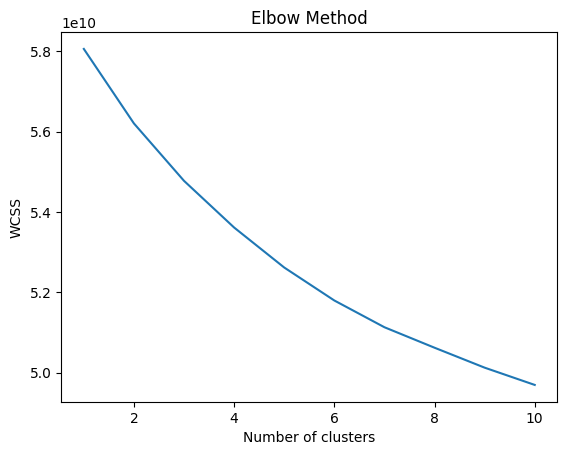

performing KMeans clustering...

Loading Images in a Dataframe done in : 1 h, 11 m, 51 s


In [9]:
# 1 --------------------------------------------------------- Loading Images in a Dataframe
# region
# @title 1 - Loading Images in a Dataframe { display-mode: "form" }
start_time = time.time()

all_entities_names = natsorted(os.listdir(ready_data_path))
print("all entities names:", all_entities_names)
filenames = []
original_data_set_size = 0
images = []  # for clustring part
for entity_name in all_entities_names:
    print("working in entity name:", entity_name)
    entity_path = os.path.join(ready_data_path, entity_name)
    entity_filenames = [file_name for file_name in os.listdir(entity_path)]
    original_data_set_size += len(entity_filenames)
    random.shuffle(entity_filenames)
    entity_filenames = entity_filenames[:int(len(entity_filenames) * (DATA_PERCENTAGE_TO_USE / 100))]
    filenames.extend([os.path.join(entity_name, file_name) for file_name in entity_filenames])

    # ----------------for clustring part
    for file_name in entity_filenames:
        img_path = os.path.join(entity_path, file_name)
        if image_is_ok(img_path):
            img = image.load_img(img_path, target_size=(image_size, image_size))
            img = image.img_to_array(img)
            images.append(img)
        else:
            print(f"file: {file_name} in entity: {entity_name} is corrupted & skipped from dataset while loading images")

 

print(f"selected data set size = {DATA_PERCENTAGE_TO_USE / 100} * {original_data_set_size} = {len(filenames)}") 
file_labels = [x.split(os.sep)[0] for x in filenames] 
data = pd.DataFrame({"filename": filenames, "label": file_labels})
# sort the data frame by the labels using natsort
data = data.iloc[natsorted(data.index.values)] 
# data = data.sort_values('label', kind='mergesort')
print("data head :", data.head())
print("data tail :", data.tail())        

# clustering part ------------------------------------------------------------

# Flatten your images into 1D arrays
print("flattening images...")
flattened_images = np.array(images).reshape(len(images), -1)

# -------------------- Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):  # change the range according to your needs
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(flattened_images)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
# -------------------------------------


# Perform KMeans clustering
print("performing KMeans clustering...")
kmeans = KMeans(n_clusters= CLUSTERS_COUNT, random_state=0).fit(flattened_images)

# Get the cluster labels for each image
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
data['cluster'] = labels

calculate_and_print_time(start_time, 'Loading Images in a Dataframe')
# print("Loading Images in a Dataframe done")
# endregion



<h1> 2 - Train Test Split <h1>

In [10]:

# ...

# Split data for each cluster
clusters = data['cluster'].unique()
train_data = {}
test_data = {}
val_data = {}

print("we have ", len(clusters), "clusters")
for cluster in clusters:
    cluster_data = data[data['cluster'] == cluster]
    labels = cluster_data['label']
    print(f"Cluster {cluster} class distribution:")
    print("total images in the current cluster:", len(cluster_data))
    print(labels.value_counts())
    X_train, X_temp = train_test_split(cluster_data, test_size=0.2, stratify=labels, random_state=42)
    label_test_val = X_temp['label']
    X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state=42)

    train_data[cluster] = X_train
    test_data[cluster] = X_test
    val_data[cluster] = X_val

    print(f"Cluster {cluster}:")
    print('The shape of train data', X_train.shape)
    print('The shape of test data', X_test.shape)
    print('The shape of validation data', X_val.shape)
    print(" ")

# ...

we have  2 clusters
Cluster 0 class distribution:
total images in the current cluster: 31572
label
أ    2495
ي    1976
غ    1404
ع    1317
ن    1289
ل    1265
ب    1259
ت    1246
ث    1243
ك    1229
س    1194
ه    1173
ح    1149
خ    1130
ق    1115
ج    1109
م    1080
ف    1069
ش    1060
و    1041
ص     894
ض     854
ز     794
ر     770
د     709
ذ     696
ظ     517
ط     495
Name: count, dtype: int64
Cluster 0:
The shape of train data (25257, 3)
The shape of test data (3157, 3)
The shape of validation data (3158, 3)
 
Cluster 1 class distribution:
total images in the current cluster: 14558
label
ض    977
ص    942
ي    793
ش    786
ف    773
ق    734
س    681
ه    678
ث    636
ك    630
ت    623
ب    609
ل    608
ن    573
ع    538
غ    433
ط    425
ظ    401
أ    356
و    331
م    320
ج    312
خ    292
ح    280
ذ    254
د    243
ر    181
ز    149
Name: count, dtype: int64
Cluster 1:
The shape of train data (11646, 3)
The shape of test data (1456, 3)
The shape of validation data (1456, 3)


<h1> 3 - Creating Image Data Generator <h1>

In [11]:
# 3 --------------------------------------------------------- Creating Image Data Generator
# region
# @title 3 - Creating Image Data Generator  { display-mode: "form" }
start_time = time.time()

image_channel = 3
if tpu:
    bat_size = 128 * strategy.num_replicas_in_sync
else:    
    bat_size = 32

# Creating image data generator
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = {}
val_generator = {}
test_generator = {}

for cluster in clusters:
    X_train = train_data[cluster]
    X_val = val_data[cluster]
    X_test = test_data[cluster]

    train_generator[cluster] = train_datagen.flow_from_dataframe(X_train,
                                                    directory = ready_data_path ,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size),
                                                    class_mode='categorical')

    val_generator[cluster] = test_datagen.flow_from_dataframe(X_val,
                                                    directory = ready_data_path ,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size),
                                                    shuffle=False,
                                                    class_mode='categorical')

    test_generator[cluster] = test_datagen.flow_from_dataframe(X_test,
                                                    directory = ready_data_path ,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size),
                                                    shuffle=False,
                                                    class_mode='categorical')

calculate_and_print_time(start_time, 'Creating Image Data Generator')

# endregion



Found 25257 validated image filenames belonging to 28 classes.
Found 3158 validated image filenames belonging to 28 classes.
Found 3157 validated image filenames belonging to 28 classes.
Found 11646 validated image filenames belonging to 28 classes.
Found 1456 validated image filenames belonging to 28 classes.
Found 1456 validated image filenames belonging to 28 classes.

Creating Image Data Generator done in : 0 h, 0 m, 7 s


<h1> 4 - Deep Learning Model <h1>

In [12]:
# 4 --------------------------------------------------------- Deep Learning Model
# region
# @title 4 - Deep Learning Model { display-mode: "form" }
start_time = time.time()

def create_model(num_classes):
    model = Sequential()

    # Input Layer
    model.add(Conv2D(32,(3,3),activation='relu', padding='same', input_shape = (image_size,image_size,image_channel)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Block 1
    model.add(Conv2D(64,(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Block 2
    model.add(Conv2D(128,(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Block 3
    model.add(Conv2D(256,(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Fully Connected layers
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(num_classes,activation='softmax'))

    return model

models = {}

for cluster in clusters:
    with strategy.scope():
        num_classes = len(train_generator[cluster].class_indices)
        models[cluster] = create_model(num_classes)
# model.summary()

calculate_and_print_time(start_time, 'Deep Learning Model')
# print("Deep Learning Model done")

# endregion



c:\Users\Dell\Desktop\Bachelor\image-classification\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(



Deep Learning Model done in : 0 h, 0 m, 1 s


<h1> 5 - Callbacks <h1>

In [13]:
# 5 --------------------------------------------------------- Callbacks
# region
# @title 5 - Callbacks { display-mode: "form" }
from gc import callbacks


start_time = time.time()

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)
 
callbacks = [learning_rate_reduction,early_stoping]
 
calculate_and_print_time(start_time, 'Callbacks')
# print("Callbacks done")

# endregion



Callbacks done in : 0 h, 0 m, 0 s


<h1> 6 - Model Compilation <h1>

In [14]:
# 6 --------------------------------------------------------- Model Compilation
# region
# @title 6 - Model Compilation { display-mode: "form" }
start_time = time.time()

for cluster in clusters:
    with strategy.scope():
        model = models[cluster]
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
calculate_and_print_time(start_time, 'Model Compilation')
# print("Model Compilation done")

# endregion

#


Model Compilation done in : 0 h, 0 m, 0 s


<h1> 7 - Model Fitting <h1>

In [15]:
# 7 --------------------------------------------------------- Model Fitting
# region
# @title 7 - Model Fitting { display-mode: "form" }
start_time = time.time()

training_histories = {}

for cluster in clusters:
    print(f"Fitting model for cluster {cluster}")
    model = models[cluster]
    train_gen = train_generator[cluster]
    val_gen = val_generator[cluster]

    print("number of samples in train generator: ", train_gen.samples)
    print("number of samples in test generator: ", test_generator[cluster].samples)
    print("batch size: ", bat_size)

    steps_per_epoch = train_gen.samples // train_gen.batch_size
    validation_steps = val_gen.samples // val_gen.batch_size

    print("steps_per_epoch: ", steps_per_epoch)
    print("validation_steps: ", validation_steps)

    with strategy.scope():
        training_history = model.fit(train_gen,
                        validation_data = val_gen,
                        callbacks=callbacks,
                        epochs = EPOCHS,
                        steps_per_epoch = steps_per_epoch,
                        validation_steps = validation_steps,
                       )
    training_histories[cluster] = training_history

calculate_and_print_time(start_time, 'Model Fitting')
# print("Model Fitting done")
# endregion

#

Fitting model for cluster 0
number of samples in train generator:  25257
number of samples in test generator:  3157
batch size:  32
steps_per_epoch:  789
validation_steps:  98
Epoch 1/100


c:\Users\Dell\Desktop\Bachelor\image-classification\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


789/789 ━━━━━━━━━━━━━━━━━━━━ 85s 89ms/step - accuracy: 0.0809 - loss: 3.6150 - val_accuracy: 0.1476 - val_loss: 3.0771 - learning_rate: 0.0010
Epoch 2/100
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 79us/step - accuracy: 0.1250 - loss: 3.0378 - val_accuracy: 0.0909 - val_loss: 3.4396 - learning_rate: 0.0010
Epoch 3/100


C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


786/789 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1394 - loss: 3.0778
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
789/789 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.1394 - loss: 3.0777 - val_accuracy: 0.0931 - val_loss: 4.0512 - learning_rate: 0.0010
Epoch 4/100
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.2500 - loss: 2.7148 - val_accuracy: 0.1364 - val_loss: 3.9422 - learning_rate: 5.0000e-04
Fitting model for cluster 1
number of samples in train generator:  11646
number of samples in test generator:  1456
batch size:  32
steps_per_epoch:  363
validation_steps:  45
Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.0652 - loss: 3.7930 - val_accuracy: 0.0514 - val_loss: 5.0733 - learning_rate: 0.0010
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 130us/step - accuracy: 0.0938 - loss: 3.2226 - val_accuracy: 0.1250 - val_loss: 4.4193 - learning_rate: 0.0010
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accu

<h1> 8 - Plot the results <h1>

Plotting training history for cluster 0


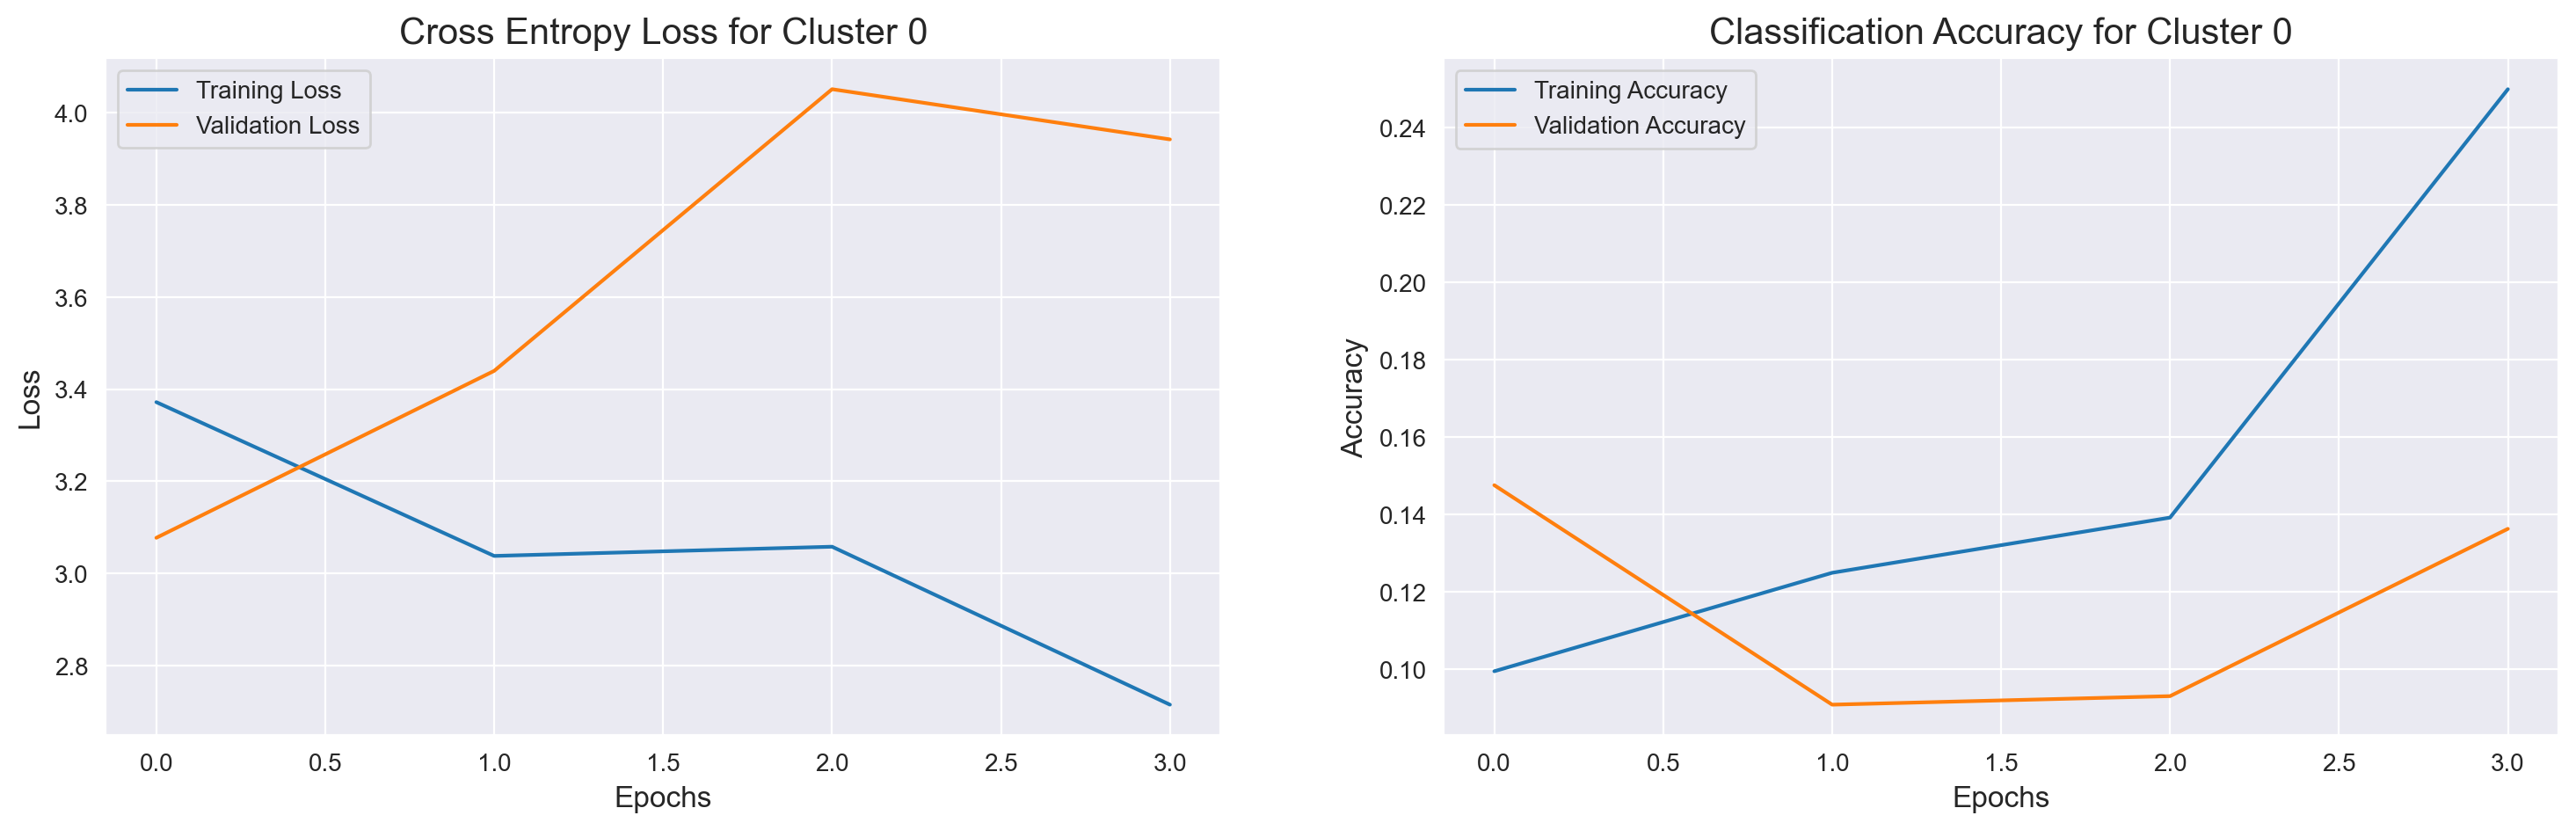

Plotting training history for cluster 1


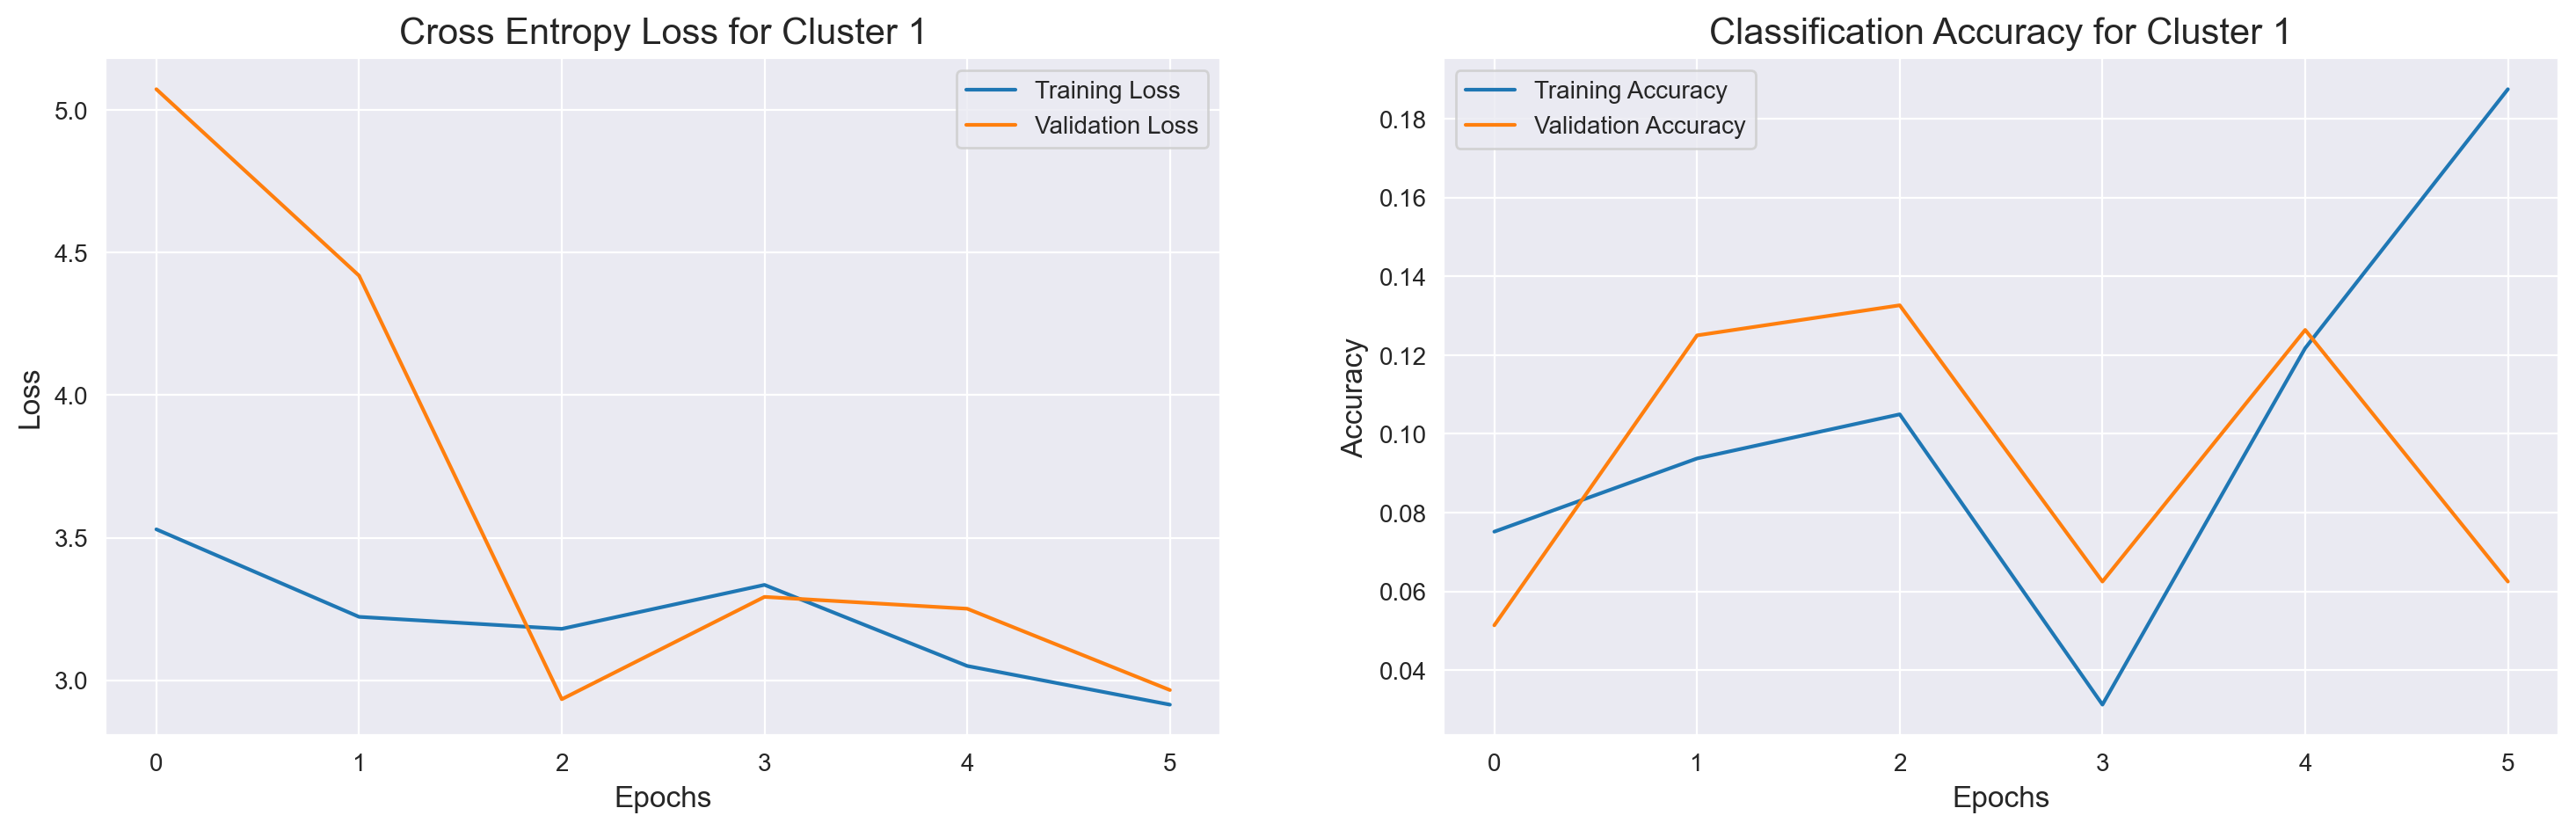


Plot the results done in : 0 h, 0 m, 0 s


In [16]:
# plots for accuracy and Loss with epochs
start_time = time.time()

for cluster in clusters:
    print(f"Plotting training history for cluster {cluster}")
    training_history = training_histories[cluster]
    error = pd.DataFrame(training_history.history)

    plt.figure(figsize=(18,5),dpi=200)
    sns.set_style('darkgrid')

    plt.subplot(121)
    plt.title(f'Cross Entropy Loss for Cluster {cluster}',fontsize=15)
    plt.xlabel('Epochs',fontsize=12)
    plt.ylabel('Loss',fontsize=12)
    plt.plot(error['loss'], label='Training Loss')
    plt.plot(error['val_loss'], label='Validation Loss')
    plt.legend()

    plt.subplot(122)
    plt.title(f'Classification Accuracy for Cluster {cluster}',fontsize=15)
    plt.xlabel('Epochs',fontsize=12)
    plt.ylabel('Accuracy',fontsize=12)
    plt.plot(error['accuracy'], label='Training Accuracy')
    plt.plot(error['val_accuracy'], label='Validation Accuracy')
    plt.legend()

    plt.show(block=False)  # hosain : prevent the popup

calculate_and_print_time(start_time, 'Plot the results')

<h1> 9 - Evaluation <h1>

In [17]:
# 9 --------------------------------------------------------- Evaluation
# region
# @title 9 - Evaluation { display-mode: "form" }
# Evaluvate for train generator
start_time = time.time()

for cluster in clusters:
    print(f"Evaluating model for cluster {cluster}")
    model = models[cluster]
    train_gen = train_generator[cluster]
    val_gen = val_generator[cluster]

    loss,acc = model.evaluate(train_gen, batch_size = bat_size, verbose = 0)

    print(f'The accuracy of the model for training data in cluster {cluster} is:',acc*100)
    print(f'The Loss of the model for training data in cluster {cluster} is:',loss)

    loss,acc = model.evaluate(val_gen, batch_size = bat_size, verbose = 0)

    print(f'The accuracy of the model for validation data in cluster {cluster} is:',acc*100)
    print(f'The Loss of the model for validation data in cluster {cluster} is:',loss)

calculate_and_print_time(start_time, 'Evaluation')
# print("Evaluation done")

#  endregion

#

Evaluating model for cluster 0
The accuracy of the model for training data in cluster 0 is: 10.931622982025146
The Loss of the model for training data in cluster 0 is: 3.5051400661468506
The accuracy of the model for validation data in cluster 0 is: 14.724509418010712
The Loss of the model for validation data in cluster 0 is: 3.07981538772583
Evaluating model for cluster 1
The accuracy of the model for training data in cluster 1 is: 12.150094658136368
The Loss of the model for training data in cluster 1 is: 3.017688035964966
The accuracy of the model for validation data in cluster 1 is: 13.18681389093399
The Loss of the model for validation data in cluster 1 is: 2.9379982948303223

Evaluation done in : 0 h, 0 m, 33 s


<h1> 10 - save the model <h1>

In [18]:
# 10 --------------------------------------------------------- save the model
# region
# @title 10 - save the model { display-mode: "form" }
start_time = time.time()
for cluster in clusters:
    print(f"Saving model for cluster {cluster}")
    model = models[cluster]
    train_gen = train_generator[cluster]

    model_name = f'model_cluster_{cluster}_img_size_{image_size}.keras'
    model.save(model_name)

    class_indices = train_gen.class_indices
    index_to_label = {index: label for label, index in class_indices.items()}
    created_json_file_name = f'index_to_label_cluster_{cluster}_img_size_{image_size}.json'

    with open(created_json_file_name, 'w', encoding='utf-8') as f:
        json.dump(index_to_label, f, ensure_ascii=False)


calculate_and_print_time(start_time, 'saving the model')
# print("Model saved")
# endregion

#

Saving model for cluster 0
Saving model for cluster 1

saving the model done in : 0 h, 0 m, 0 s


<h1> 11 - Prediction <h1>

In [19]:
# 11 --------------------------------------------------------- Prediction
# region
# @title 11 - Prediction { display-mode: "form" }
start_time = time.time()
for cluster in clusters:
    print(f"Making predictions for cluster {cluster}")
    model = models[cluster]
    test_gen = test_generator[cluster]

    result = model.predict(test_gen, batch_size = bat_size, verbose = 0)

    y_pred = np.argmax(result, axis = 1)

    y_true = test_gen.labels

    loss,acc = model.evaluate(test_gen, batch_size = bat_size, verbose = 0)

    print(f'The accuracy of the model for testing data in cluster {cluster} is:',acc*100)
    print(f'The Loss of the model for testing data in cluster {cluster} is:',loss)

calculate_and_print_time(start_time, 'Prediction')
# print("Prediction done")

# endregion

#

Making predictions for cluster 0
The accuracy of the model for testing data in cluster 0 is: 15.14095664024353
The Loss of the model for testing data in cluster 0 is: 3.104976177215576
Making predictions for cluster 1
The accuracy of the model for testing data in cluster 1 is: 13.59890103340149
The Loss of the model for testing data in cluster 1 is: 2.9515645503997803

Prediction done in : 0 h, 0 m, 6 s


<h1> 12 - Classification Report <h1>

In [20]:
# 12 --------------------------------------------------------- Classification Report
# region
# @title 12 - Classification Report { display-mode: "form" }
start_time = time.time()

for cluster in clusters:
    print(f"Generating classification report for cluster {cluster}")
    model = models[cluster]
    test_gen = test_generator[cluster]

    result = model.predict(test_gen, batch_size = bat_size, verbose = 0)
    y_pred = np.argmax(result, axis = 1)
    y_true = test_gen.labels

    # Assuming all_entities_names is a list of class names in the correct order
    print("all entities names:", all_entities_names)
    print(classification_report(y_true, y_pred, target_names=all_entities_names))

calculate_and_print_time(start_time , 'Classification Report')
# print("Classification Report done")

# endregion

#

Generating classification report for cluster 0
all entities names: ['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي']
              precision    recall  f1-score   support

           أ       0.23      0.91      0.37       249
           ب       0.13      0.12      0.12       126
           ت       0.33      0.01      0.02       124
           ث       0.25      0.02      0.03       124
           ج       0.19      0.03      0.05       111
           ح       0.00      0.00      0.00       115
           خ       0.00      0.00      0.00       113
           د       0.03      0.04      0.04        71
           ذ       0.00      0.00      0.00        70
           ر       0.06      0.03      0.04        77
           ز       0.00      0.00      0.00        80
           س       0.22      0.42      0.29       119
           ش       0.00      0.00      0.00       106
           ص       0.18      0.06  

c:\Users\Dell\Desktop\Bachelor\image-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dell\Desktop\Bachelor\image-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dell\Desktop\Bachelor\image-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

all entities names: ['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي']
              precision    recall  f1-score   support

           أ       0.00      0.00      0.00        36
           ب       0.16      0.11      0.13        61
           ت       0.00      0.00      0.00        62
           ث       0.10      0.75      0.18        64
           ج       0.00      0.00      0.00        31
           ح       0.00      0.00      0.00        28
           خ       0.00      0.00      0.00        29
           د       0.00      0.00      0.00        24
           ذ       0.08      0.04      0.05        25
           ر       0.00      0.00      0.00        18
           ز       0.00      0.00      0.00        15
           س       0.23      0.24      0.23        68
           ش       0.21      0.05      0.08        78
           ص       0.20      0.44      0.27        94
           ض       0.15     

c:\Users\Dell\Desktop\Bachelor\image-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dell\Desktop\Bachelor\image-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dell\Desktop\Bachelor\image-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

<h1> 13 - Confusion Matrix <h1>

Generating confusion matrix for cluster 0


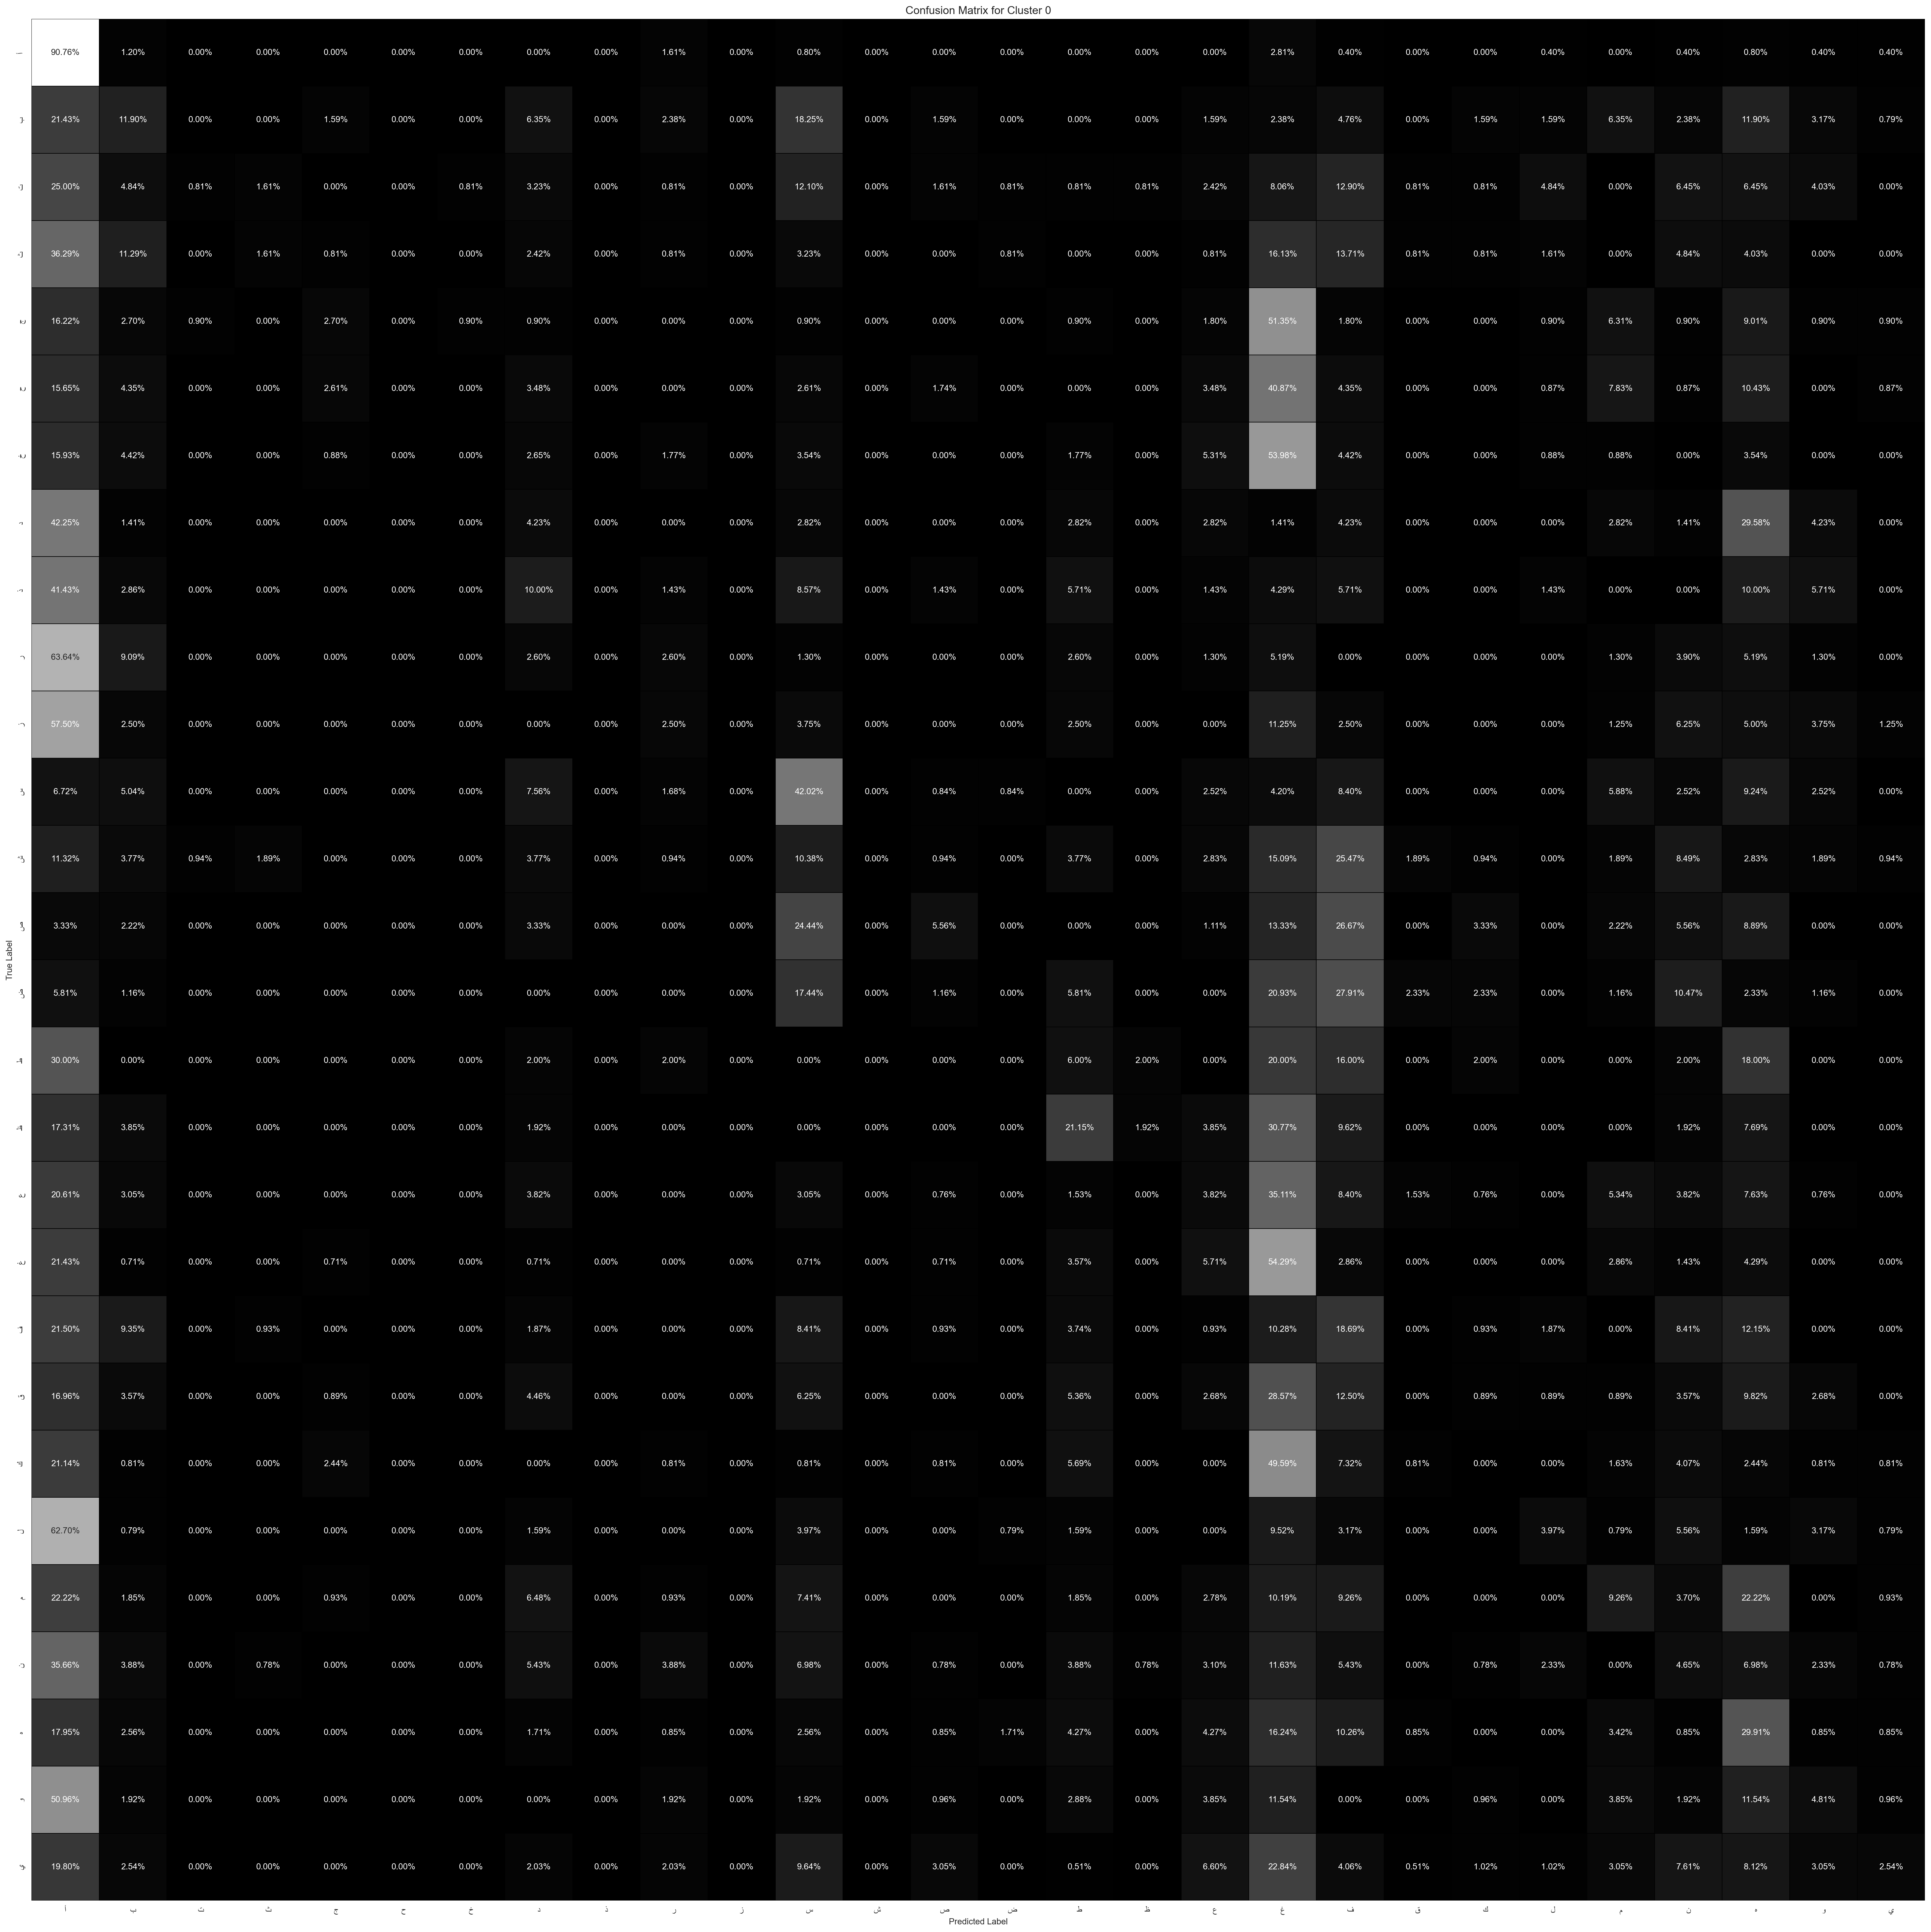

Accuracy for class ( أ ) in cluster 0 : 90.76%
Class (أ) was wrongly seen as class (ب) in cluster 0 in 1.20% of cases
Class (أ) was wrongly seen as class (ر) in cluster 0 in 1.61% of cases
Class (أ) was wrongly seen as class (س) in cluster 0 in 0.80% of cases
Class (أ) was wrongly seen as class (غ) in cluster 0 in 2.81% of cases
Class (أ) was wrongly seen as class (ف) in cluster 0 in 0.40% of cases
Class (أ) was wrongly seen as class (ل) in cluster 0 in 0.40% of cases
Class (أ) was wrongly seen as class (ن) in cluster 0 in 0.40% of cases
Class (أ) was wrongly seen as class (ه) in cluster 0 in 0.80% of cases
Class (أ) was wrongly seen as class (و) in cluster 0 in 0.40% of cases
Class (أ) was wrongly seen as class (ي) in cluster 0 in 0.40% of cases

Accuracy for class ( ب ) in cluster 0 : 11.90%
Class (ب) was wrongly seen as class (أ) in cluster 0 in 21.43% of cases
Class (ب) was wrongly seen as class (ج) in cluster 0 in 1.59% of cases
Class (ب) was wrongly seen as class (د) in cluster 0

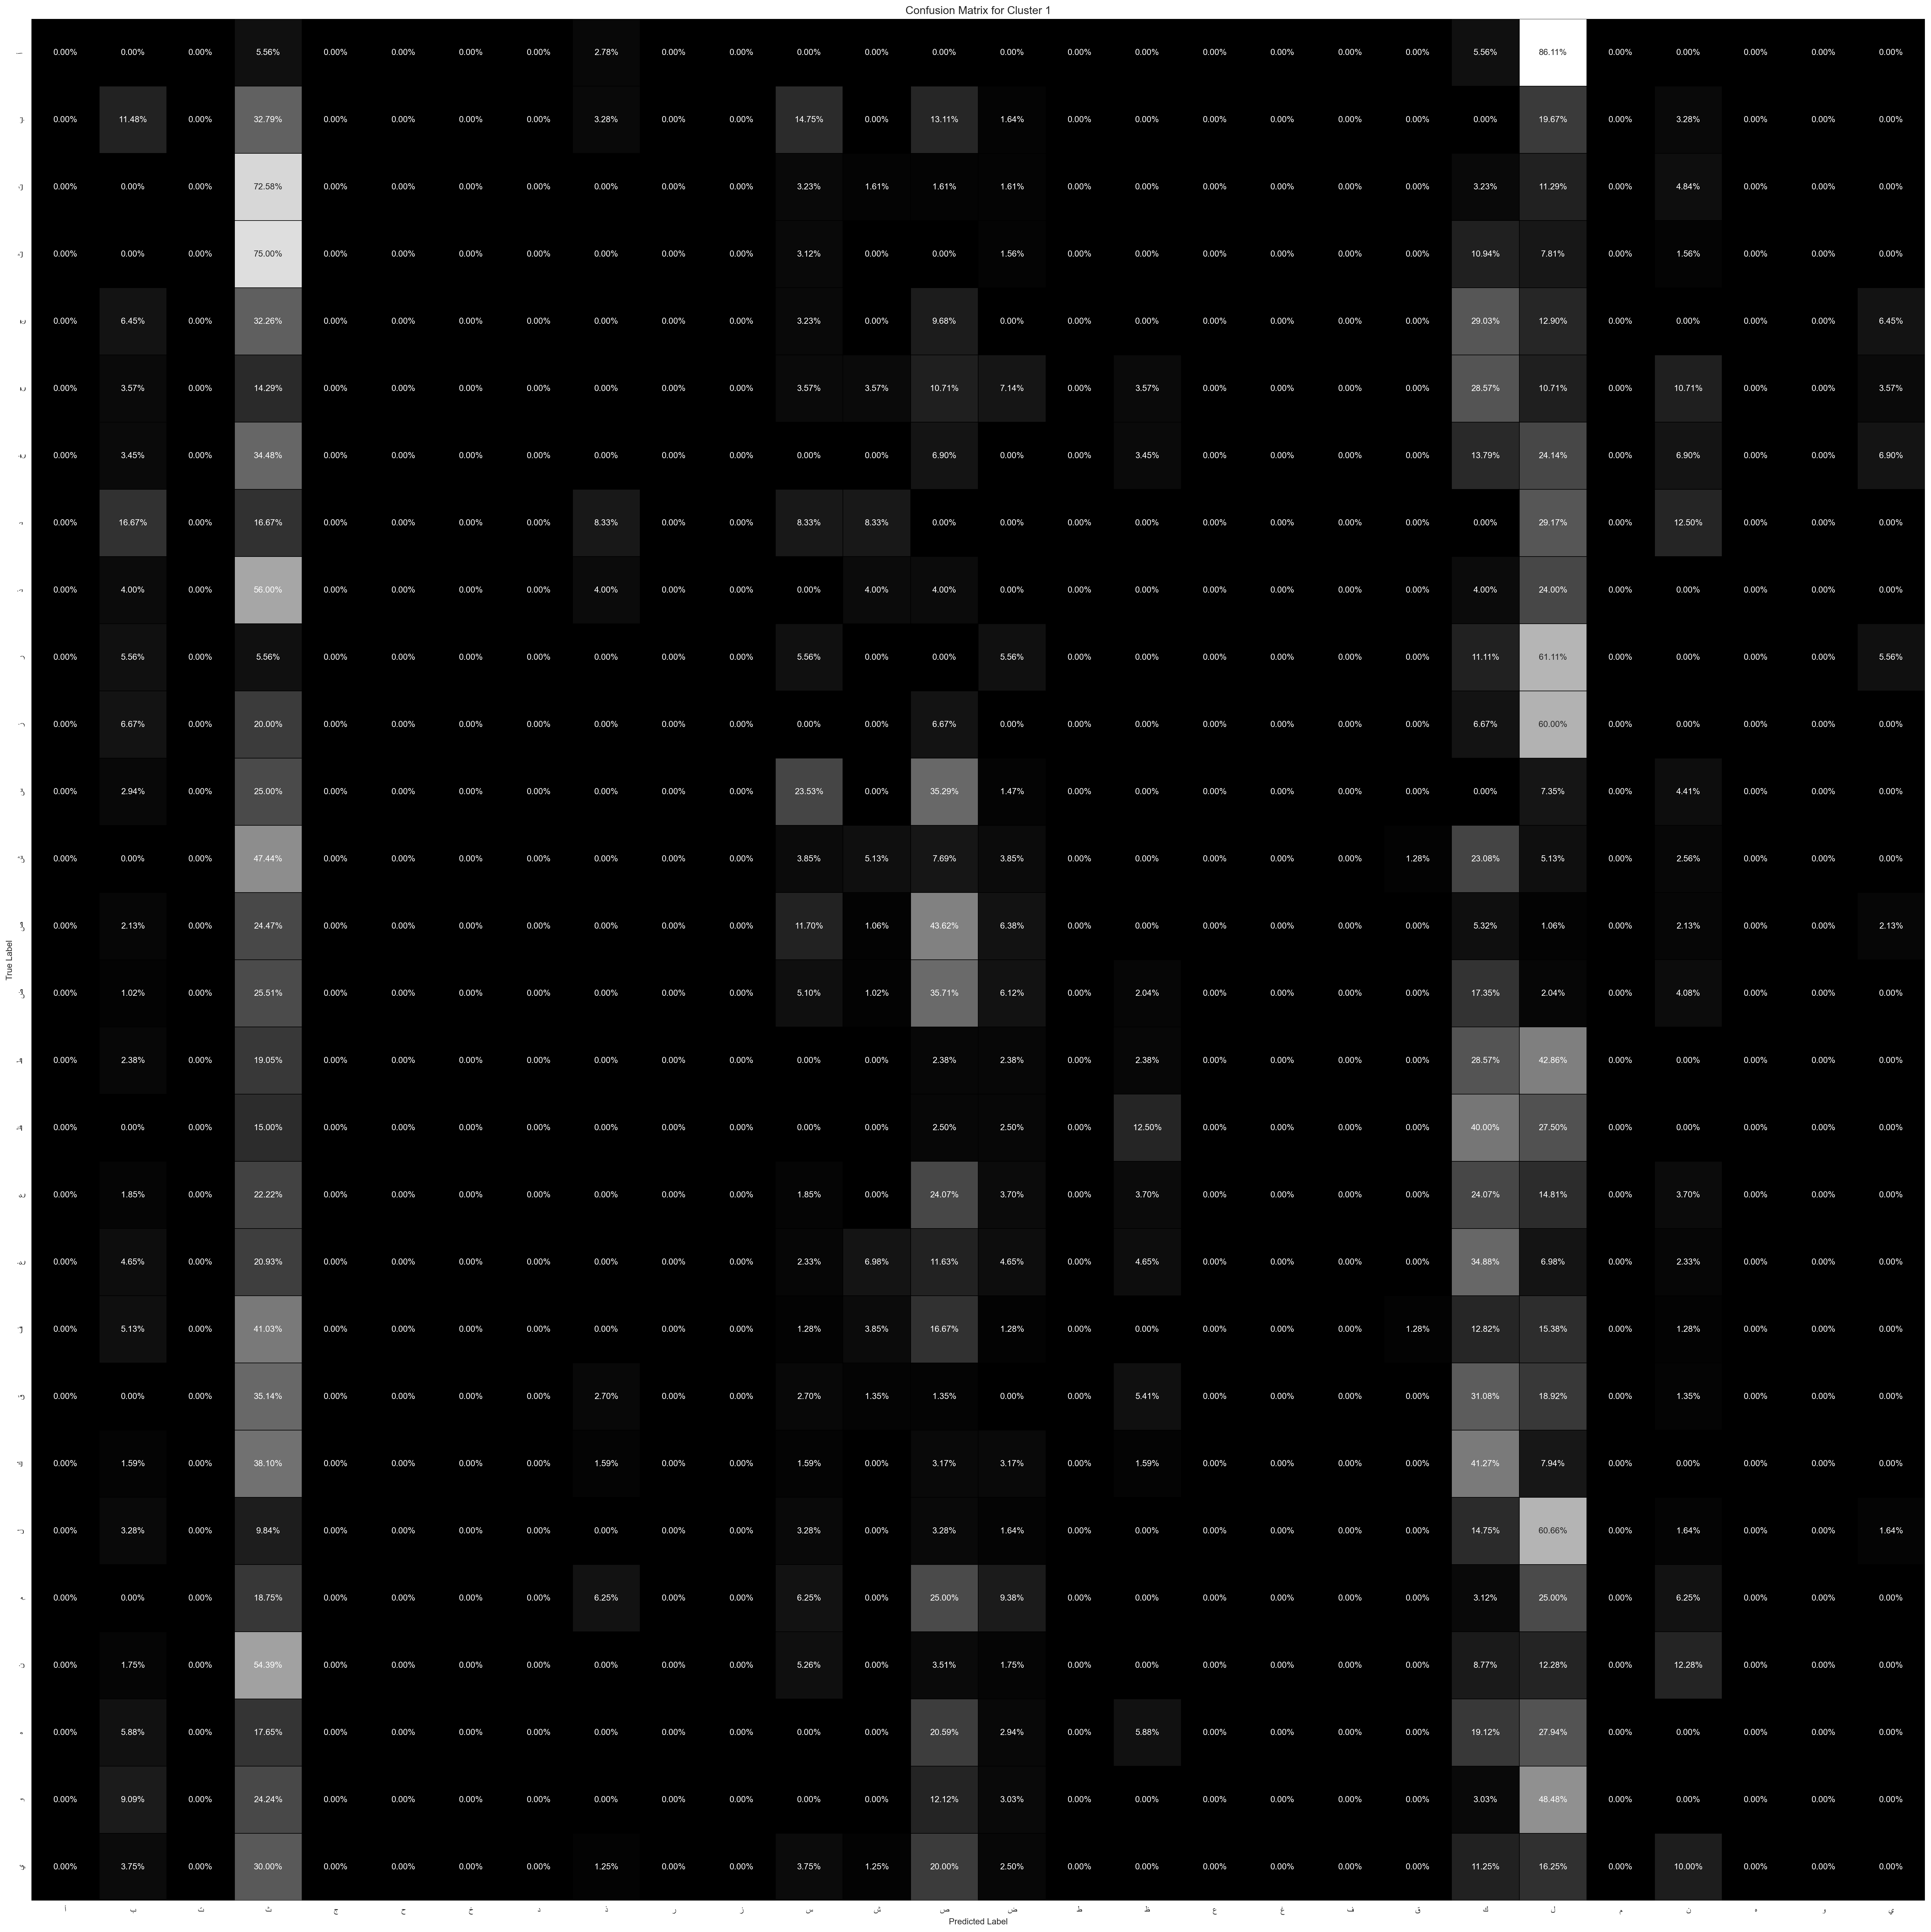

Accuracy for class ( أ ) in cluster 1 : 0.00%
Class (أ) was wrongly seen as class (ث) in cluster 1 in 5.56% of cases
Class (أ) was wrongly seen as class (ذ) in cluster 1 in 2.78% of cases
Class (أ) was wrongly seen as class (ك) in cluster 1 in 5.56% of cases
Class (أ) was wrongly seen as class (ل) in cluster 1 in 86.11% of cases

Accuracy for class ( ب ) in cluster 1 : 11.48%
Class (ب) was wrongly seen as class (ث) in cluster 1 in 32.79% of cases
Class (ب) was wrongly seen as class (ذ) in cluster 1 in 3.28% of cases
Class (ب) was wrongly seen as class (س) in cluster 1 in 14.75% of cases
Class (ب) was wrongly seen as class (ص) in cluster 1 in 13.11% of cases
Class (ب) was wrongly seen as class (ض) in cluster 1 in 1.64% of cases
Class (ب) was wrongly seen as class (ل) in cluster 1 in 19.67% of cases
Class (ب) was wrongly seen as class (ن) in cluster 1 in 3.28% of cases

Accuracy for class ( ت ) in cluster 1 : 0.00%
Class (ت) was wrongly seen as class (ث) in cluster 1 in 72.58% of cases
C

In [21]:

# 13 --------------------------------------------------------- Confusion Matrix
# Normalize the confusion matrix
# region
# @title 13 - Confusion Matrix { display-mode: "form" }
start_time = time.time()

from sklearn.metrics import confusion_matrix

for cluster in clusters:
    print(f"Generating confusion matrix for cluster {cluster}")
    model = models[cluster]
    test_gen = test_generator[cluster]

    result = model.predict(test_gen, batch_size = bat_size, verbose = 0)
    y_pred = np.argmax(result, axis = 1)
    y_true = test_gen.labels

    confusion_mtx = confusion_matrix(y_true, y_pred)
    confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

    num_classes = confusion_mtx.shape[0]
    figsize = 40  # adjust as needed

    f, ax = plt.subplots(figsize=(figsize, figsize), dpi=200)
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap="gist_yarg_r", linecolor="black", fmt='.2%', ax=ax, cbar=False, xticklabels=all_entities_names, yticklabels=all_entities_names)

    plt.xlabel("Predicted Label", fontsize=10)
    plt.ylabel("True Label", fontsize=10)
    plt.title(f"Confusion Matrix for Cluster {cluster}", fontsize=13)

    plt.show()

    # Print accuracy for each class
    for i in range(num_classes):
        true_positives = confusion_mtx[i, i]
        accuracy = true_positives * 100  # convert to percentage
        print(f"Accuracy for class ( {all_entities_names[i]} ) in cluster {cluster} : {accuracy:.2f}%")

        # Print confusion with other classes
        for j in range(num_classes):
            if i != j and confusion_mtx[i, j] > 0:
                confusion = confusion_mtx[i, j] * 100  # convert to percentage
                print(f"Class ({all_entities_names[i]}) was wrongly seen as class ({all_entities_names[j]}) in cluster {cluster} in {confusion:.2f}% of cases")
        print()


# Print accuracy for each class
for i in range(num_classes):
    true_positives = confusion_mtx[i, i]
    accuracy = true_positives * 100  # convert to percentage
    print(f"Accuracy for class ( {all_entities_names[i]} ) : {accuracy:.2f}%")

    # Print confusion with other classes
    for j in range(num_classes):
        if i != j and confusion_mtx[i, j] > 0:
            confusion = confusion_mtx[i, j] * 100  # convert to percentage
            print(f"Class ({all_entities_names[i]}) was wrongly seen as class ({all_entities_names[j]}) in {confusion:.2f}% of cases")
    print()        

calculate_and_print_time(start_time , 'Confusion Matrix')
# print("Confusion Matrix done")

# endregion 

<h1> 14 - Execution Time <h1>

In [22]:
# 14 --------------------------------------------------------- Execution Time
# region
# @title 14 - Execution time  { display-mode: "form" }

calculate_and_print_time(global_start_time , 'Whole notebook execution time')





Whole notebook execution time done in : 1 h, 16 m, 29 s


<h1> 15 - reference codes <h1>

In [23]:
# --------------------------------------------------------- reference codes
# region
#  @title  reference codes { display-mode: "form" }

# from google.colab import drive
# drive.mount('/content/gdrive')

# import zipfile
# import os
# extract_source = "/content/gdrive/My Drive/GUC Bachelor : Arabic Image-to-Letters Script Recognition/data set/data set 2.zip"
# extract_destination = "/content/extracted_from_drive"
# zip_ref = zipfile.ZipFile(extract_source, 'r')
# print("extracting...")
# zip_ref.extractall(extract_destination)
# extracted_folder_name = os.listdir(extract_destination)[0]
# zip_ref.close()
# print("extracted files from drive to colab successfully !")
# all_entities_path = os.path.join(extract_destination, extracted_folder_name)


# def get_corrupted_files_paths(all_entities_path):
#     all_entities_names = os.listdir(all_entities_path)
#     corrupted_file_paths = set()
#     print("\nVerifying all files are non-corrupted images...")
#     for entity_name in all_entities_names:
#         entity_path = os.path.join(all_entities_path, entity_name)
#         for filename in os.listdir(entity_path):
#             file_path = os.path.join(entity_path, filename)
#             if not image_is_ok(file_path):
#                 print(f"File {file_path} is corrupted and will be skipped.")
#                 corrupted_file_paths.add(file_path)
#     print("Your data is ok." if not corrupted_file_paths else "Done reporting error files.")
#     return corrupted_file_paths

